# Inferring Galaxy Cluster Masses from X-ray Images with Convolutional Neural Networks

In this experiment, we use convolutional neural networks (CNNs) to estimate the masses of galaxy clusters from simulated X-ray images. This involves designing and training the model using a labelled dataset, which includes cluster images and corresponding redshift values, to predict the masses. We will begin by discussing the structure and preprocessing of the training and prediction data. Next, we will explore the model architecture and the training procedure along with the custom loss function. Finally, we will assess how effectively the model predicts the masses of the galaxy clusters.

In [1]:
import numpy as np
import random
import tensorflow as tf
from histogram import get_data, plot_cluster_histograms
from data_importer import load_images
from pre_process import normalize_data, split_data
from model import build_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from make_my_plot import plot_training_history, plot_true_vs_predicted, plot_residuals

#To remove warnings
import warnings
warnings.filterwarnings('ignore')

2025-05-30 15:31:22.768980: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-30 15:31:22.797247: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-30 15:31:22.797278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-30 15:31:22.798613: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-30 15:31:22.804261: I tensorflow/core/platform/cpu_feature_gua

We set the random seed for python, numpy and keras, allowing reproducable results.

In [2]:
seed_value = 59 #This is used wherever a seed value is required ahead. 
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

### 1. Understanding the Data

#### 1.1 Distribution of the Cluster Masses and Redshifts

The data contains the images and the labels, which are stored in the *.pickle* and *.f* files, respectively. The `get_data` function loads the images in a dictionary datatype and their corresponding labels in arrays. In our case, the labels are the cluster masses and redshift values. The `plot_cluster_histograms` function uses the matplotlib.pyplot library to plot the histogram for the given data using a custom bin size. 

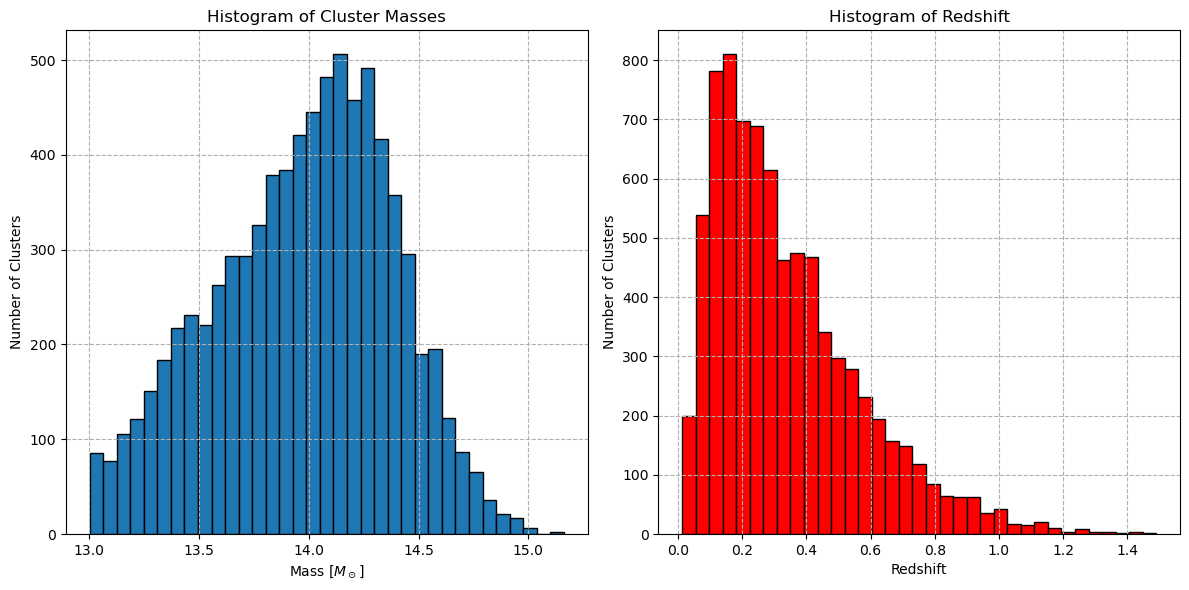

In [3]:
data_directory = '/home/r/Rajat.Saxena/AI Lab/1. X_ray_mass/'
image_file = 'eFEDS_01to18-3dImgs-7946clus-300pix-50pix-ext_det_thr.pickle'
catalog_file = 'eFEDS_mock_clusters_catalog_01to18-ext_det_thr.f'

images, labels = get_data(image_p=data_directory+image_file, catalog_f=data_directory+catalog_file)
log_mass = labels[:, 0]       
redshift = labels[:, 1]

plot_cluster_histograms(log_mass, redshift, 35)

#### 1.2 Loading the Image Data

The `get_data` function gives images in the dictionary datatype, which is inconvenient to use. Hence, a new function `load_images` is used to load the data as numpy arrays. Printing the shape of `img` suggests that we have 7946 images, each of 50 $\times$ 50 and across 10 frequency channels. The grid size of the image is important because this will be the size of the input layer in the CNN.

In [4]:
img = load_images(data_directory, image_file, 'gsm_3dImgs')
img.shape

(7946, 50, 50, 10)

## 2. Preparing the data for training 

### 2.1 Normalising the data

It is known that models learn and perform better with inputs at zero mean and unit variance [[1]](https://melfm.github.io/posts/2018-08-Understanding-Normalization/). Hence, the data is normalised using the function `normalize_data`. Which performs the following operation: $$ \frac{x_i - \mu}{\sigma} $$
Where $x_i$ are the array elements, $\mu$ is the mean, and $\sigma$ is the standard deviation of the array. Both redshifts and masses will be used in training; hence, both are normalised. 

In [5]:
norm_mass= normalize_data(log_mass)
norm_redshift = normalize_data(redshift)

### 2.2 Splitting the data into Training, Validation and Prediction sets

*Training data* is the data the neural network uses to learn patterns and update its weights during model training. \
*Validation data* is a separate dataset used during training to monitor the model’s performance and tune hyperparameters, helping prevent overfitting.\
*Prediction (or test) data* is unseen data that the trained model provides to evaluate its final performance and generalisation ability.

The function `split_data` splits all the image, redshift, and mass data into training, validation, and prediction data sets. It uses the function `train_test_split` from the `sklearn` library, which randomly distributes the data while keeping the image-label correspondence. This ensures the model gets training data with no patterns in arrangements. The user can choose the percentage of data in each set. The random seed allows the randomised operations to be reproducible. 

Caution: The `split_data` function creates the datasets in two steps. First, it splits the data into a temporary and a prediction dataset; the first floating argument in the function decides the percentage of the split (Prediction data). Second, the temporary dataset is split into training and validation datasets based on the second floating argument in the function. Hence, the data is not divided into exact percentages given as inputs. 

In [6]:
(X_train, X_val, X_predict,
 y_train, y_val, y_predict,
 redshift_train, redshift_val, redshift_predict) = split_data(img, norm_mass, norm_redshift, 0.2, 0.20, seed_value)

The percentage of total data in each dataset.

In [7]:
print(f"{X_train.shape[0]/norm_mass.shape[0] * 100 :.2f}% of total data in Training Data")
print(f"{X_val.shape[0]/norm_mass.shape[0] * 100 :.2f}% of total data in Validation Data")
print(f"{X_predict.shape[0]/norm_mass.shape[0] * 100 :.2f}% of total data in Prediction Data")

63.98% of total data in Training Data
16.01% of total data in Validation Data
20.01% of total data in Prediction Data


## 3. Designing the Model

### 3.1 Model Architecture

The model is designed to perform a regression task using image data and an additional scalar input (redshift). It outputs two values: the predicted mean and the log-variance, enabling it to use heteroscedastic loss. 

#### 3.1.1 Convolution Layer

The input layer is the size of the image, i.e. (50, 50, 10). Further, the convolutional layers were added using `layers.Conv2D` because the images are 2D structures. After repeated tries, the filter sizes and the number of neurons in each layer were optimised. The LeakyReLU allows the model to learn complex, non-linear mappings between inputs and outputs. It also prevents the neurons from "dying" during training for negative values. Convolution ends with the final flatten layer, which converts the spatial features into a vector suitable for dense layers. For convolution the data is passed through three layers. First two layers each has 16 neurons and both with a filter of 4 $\times$ 4. The third layer has 32 neurons with a filter of 2 $\times$ 2.

#### 3.1.2 Pooling
After the convolution the data is passed through a Pooling layer. Pooling is a downsampling operation to reduce the spatial dimensions (height and width) of feature maps. It helps decrease computational load, control overfitting, and retain important features. This layer performs 2 $\times$ 2 average pooling with a stride of 1, meaning it slides the window one pixel at a time, computing the average in each region. With `padding="valid"`, no padding is added, so the output is slightly smaller. 


#### 3.1.3 Adding Redshift

Generally, galaxy clusters at higher redshift are less massive than those at lower redshift [[2]](https://doi.org/10.1051/0004-6361/201527630). Redshifts, along with the X-ray image data, can improve the model's predictions. Hence, after flattening the image data, the normalised value of z is concatenated with it and then fed to the densely connected layer.

#### 3.1.4 Dense Layer

This layer is called dense as all neurons from the first layer are connected with all other neurons in the second layer. The combined vector is passed through three fully connected layers with decreasing units (32 → 16 → 8), each followed by LeakyReLU activations, progressively compressing the representation. Finally, giving two outputs: predicted mean and log variance. 

### 3.2 Compiling the model

Compiling a model involves specifying:
- The optimizer – how the model updates weights.
- The loss function – what the model tries to minimise.
- Any additional metrics for tracking performance during training.

#### 3.2.1 Optimizer
Adam (short for Adaptive Moment Estimation) is an optimiser that allows adaptive learning rates. The learning rate is set relatively low to help ensure that training is stable and smooth, especially important in models that predict both values and uncertainties.

#### 3.2.2 Loss Function
The `heteroscedastic_loss` function is based on the negative log-likelihood of a Gaussian distribution, and it penalises:
- Large differences between the predicted mean and the actual value.
- Overconfident predictions with minor predicted variances that turn out to be wrong.

The `heteroscedastic_loss` function calculates the following probability. 
$$ L\left( y|x, \theta \right) = \frac{(y - \mu(x,\theta)^2)}{2 \sigma(x, \theta)^2} - \frac{\log(2 \sigma(x, \theta)^2)}{2} $$

Where $L$ is the log likelihood, $y$ denotes the mass in our dataset, $x$ the image, $\sigma$ is the standard deviation and $\theta$ summarises our neural network parameters. $\mu$ and $\sigma$ are function of $(x,\theta)$ because they are the outputs of the model. The `tf.reduce_mean()` computes the mean loss over all samples in the batch, returning a single scalar value.

#### 3.2.3 Metrics
Metrics are used to monitor training and validation performance during each epoch. Here, we're tracking the same loss function heteroscedastic_loss as a metric.

The function `build_model` uses Keras, which is based on TensorFlow, to build the architecture and compile the model.

In [8]:
model = build_model()

2025-05-30 15:31:28.099517: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-30 15:31:28.120023: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-30 15:31:28.120230: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

`model.summary` gives the architecture and complexity of the model at a glance.

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 50, 50,    │          0 │ -                 │
│ (InputLayer)        │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 47, 47,    │      2,576 │ image_input[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 44, 44,    │      4,112 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 43, 43,    │      2,080 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 42, 42,    │          0 │ conv2d_2[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 56448)     │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ redshift_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56449)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ redshift_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │  1,806,400 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │        136 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 2)         │         18 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,815,850 (6.93 MB)

 Trainable params: 1,815,850 (6.93 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Training the Model

### 4.1 Early Stopping 

The `EarlyStopping` callback is used to prevent overfitting and save training time by halting the training process when the model stops improving on the validation set.

In [10]:
early_stop = EarlyStopping(
    monitor='val_loss',          # Monitor the validation loss
    patience=5,                  # Stop training if no improvement for a certain number of epochs
    restore_best_weights=True,   # Restores the model weights from the epoch with the best validation loss
    verbose=1                    # Print message when training stops
)

### 4.2 Reduce Learning Rate

The `ReduceLROnPlateau` callback helps the model continue learning by reducing the learning rate when the validation performance stalls. This often helps escape flat regions or local minima in the loss landscape.

In [11]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # Monitor the validation loss
    factor=0.5,           # Reduce learning rate by this factor
    patience=5,           # Wait this many epochs before reducing
    min_lr=1e-9           # Do not reduce below this learning rate
)

### 4.3 Training

We train the compiled model using the `fit()` function, which takes in both the training data and validation data. The training is guided by our two callbacks: EarlyStopping (to prevent overfitting) and ReduceLROnPlateau (to fine-tune the learning rate when progress stalls).

In [12]:
#Training the Model
history = model.fit(
    [X_train, redshift_train],        # Input: image and redshift data
    y_train,                          # Target values (mean and log variance)
    epochs=100,                        # Max number of training epochs
    validation_data=([X_val, redshift_val], y_val),  # Validation set
    batch_size=32,                    # Number of samples per gradient update
    callbacks=[early_stop, reduce_lr] # Use callbacks during training
)

Epoch 1/100


2025-05-30 15:31:30.201770: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-30 15:31:30.321902: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - heteroscedastic_loss: 0.4806 - loss: 0.4806 - val_heteroscedastic_loss: 0.3934 - val_loss: 0.3935 - learning_rate: 1.0000e-04
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - heteroscedastic_loss: 0.3410 - loss: 0.3410 - val_heteroscedastic_loss: 0.2440 - val_loss: 0.2440 - learning_rate: 1.0000e-04
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - heteroscedastic_loss: 0.1627 - loss: 0.1627 - val_heteroscedastic_loss: 0.1623 - val_loss: 0.1622 - learning_rate: 1.0000e-04
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - heteroscedastic_loss: 0.0477 - loss: 0.0477 - val_heteroscedastic_loss: 0.1169 - val_loss: 0.1169 - learning_rate: 1.0000e-04
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - heteroscedastic_loss: -0.0287 - loss: -0.0287 - val_heteroscedastic_loss: 0.0978 - val_loss: 0.0974 - learning_rate: 1.0000e-04
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - heteroscedastic_loss: -0.0938 - loss: -0.0938 - v

### 4.4 Training and Validation Loss Curves

The `plot_training_history` function generates a plot that visualises the loss curves from the training history of a Keras model. Specifically, it shows four key metrics over the training epochs: the standard training loss (loss), the validation loss (val_loss), the training heteroscedastic loss (heteroscedastic_loss), and the validation heteroscedastic loss (val_heteroscedastic_loss). It shows how well the model fits the data and how effectively it is modelling uncertainty through the heteroscedastic loss. This can be useful for diagnosing overfitting and underfitting.

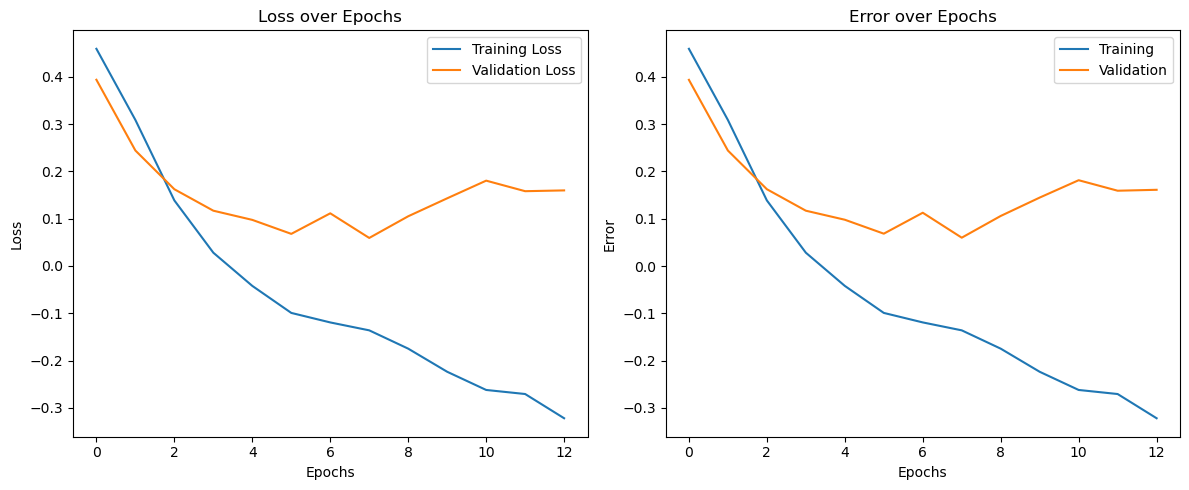

In [13]:
plot_training_history(history.history['loss'], history.history['val_loss'],
                      history.history['heteroscedastic_loss'], history.history['val_heteroscedastic_loss'])

## 5. Results

The `model.predict` function gives the predicted values of the log(mass) corresponding to the input image and redshift. 

In [14]:
predicted_mass = model.predict([X_predict, redshift_predict]) #Stores the predict log(mass) values

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


### 5.1 Plotting the Predicted Mass

The `plot_true_vs_predicted` function uses the matplotlib.pyplot library to plot the scatter of the actual values vs the masses predicted by the model. Points close to the red dotted line indicate good predictions; points far from it show errors.

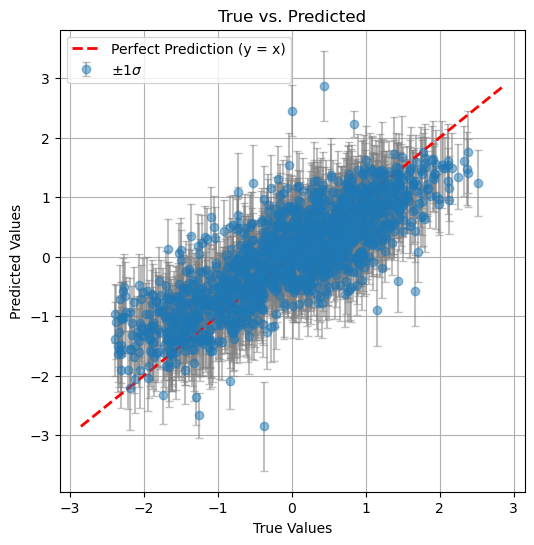

In [15]:
plot_true_vs_predicted(y_predict, predicted_mass[:,0], np.exp(predicted_mass[:,1]/2))

### 5.2 Plotting the Residuals

The `plot_residuals` uses the matplotlib.pyplot library to plot the residuals of predicted vs. true data. The residuals are calculated by subtracting the predicted value from the true value. They should be unbiased and randomly scattered with no clear pattern. Points close to the black dotted line indicate good predictions; points far from it show errors.

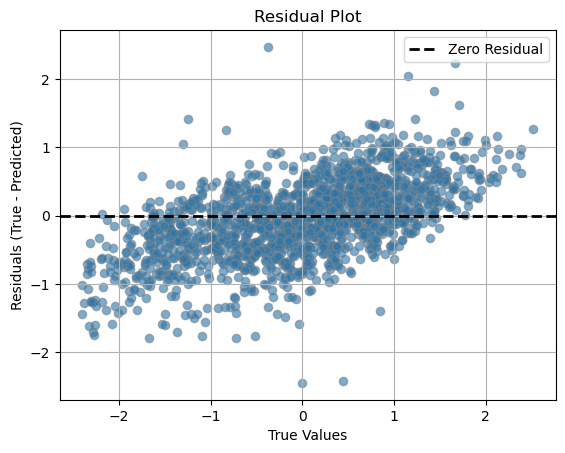

In [16]:
plot_residuals(y_predict, predicted_mass[:,0])

### 5.3 Checking σ Consistency of the Model Predictions

We evaluate how well the predicted uncertainties from our CNN model align with the true values of cluster masses. We perform a $1\sigma$ consistency check by calculating the percentage of true masses that fall within the predicted confidence interval $\pm 1 \sigma$. This interval corresponds to a 68.27% confidence level. For a good model, approximately 68% of the true values should fall within this range.

In [17]:
within_sigma = np.abs(y_predict - predicted_mass[:,0]) <= 1 * np.exp(predicted_mass[:,1]/2)

print(f"{np.mean(within_sigma) * 100:.2f}% of true cluster masses lie within ±1σ of the predicted mean.")

66.35% of true cluster masses lie within ±1σ of the predicted mean.
